## Football Events Dataset

### Pre-processing the data

In [1]:
import pandas as pd

In [2]:
#events.csv contains event data about each game.
events_n = pd.read_csv("events.csv")

#ginf.csv contains metadata and market odds about each game.
ginf = pd.read_csv("ginf.csv")

In [3]:
events_n.head(1)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0


In [4]:
ginf.head(1)

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN


In [5]:
#dictionary.txt contains a dictionary with the textual description of each categorical variable coded with integers
# list -> dictionary, eg. ["event_type" : {1 : Announcenemt}, ...]
dictionary = {}
with open("dictionary.txt") as input_file:
    previous_token = None
    for line in input_file:
        line_no_delim = line.split()
        if len(line_no_delim) == 1:
            previous_token = line_no_delim[0]
            dictionary[previous_token] = {}
        elif len(line_no_delim) >= 2:
            dictionary[previous_token][int(line_no_delim[0])] = " ".join(line_no_delim[1:])


In [6]:
import json

print(json.dumps(dictionary, indent=4))

{
    "event_type": {
        "0": "Announcement",
        "1": "Attempt",
        "2": "Corner",
        "3": "Foul",
        "4": "Yellow card",
        "5": "Second yellow card",
        "6": "Red card",
        "7": "Substitution",
        "8": "Free kick won",
        "9": "Offside",
        "10": "Hand ball",
        "11": "Penalty conceded"
    },
    "event_type2": {
        "12": "Key Pass",
        "13": "Failed through ball",
        "14": "Sending off",
        "15": "Own goal"
    },
    "side": {
        "1": "Home",
        "2": "Away"
    },
    "shot_place": {
        "1": "Bit too high",
        "2": "Blocked",
        "3": "Bottom left corner",
        "4": "Bottom right corner",
        "5": "Centre of the goal",
        "6": "High and wide",
        "7": "Hits the bar",
        "8": "Misses to the left",
        "9": "Misses to the right",
        "10": "Too high",
        "11": "Top centre of the goal",
        "12": "Top left corner",
        "13": "Top right cor

As we can see, in the events dataset, there are some columns that are labelled by integers. These integers can now be referenced by the dictionary we just pre-processed. Now we replace the values instead of integer values on both the tables for better undesrstanding.


In [7]:
events = events_n.replace(dictionary)
ginf = ginf.replace(dictionary)

import numpy as np

print(f"There are {np.size(events.id_odsp.unique())} unique rows in the events table")
print(f"There are {np.size(ginf.id_odsp.unique())} rows in the ginf table")

There are 9074 unique rows in the events table
There are 10112 rows in the ginf table


As we can see above, for some events, there isn't any available metadata about that event. So we only consider those events that have more available information. To do this, we perform a left-join operation, with the events table being on the left side.

In [8]:
data = events.merge(ginf, on="id_odsp", how="left")

data.head(1)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Key Pass,Away,Hamburg SV,Borussia Dortmund,...,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN


In [9]:
data.league.unique()

array(['D1', 'F1', 'SP1', 'I1', 'E0'], dtype=object)

The description of the dataset says that these are the top 5 european leagues. But, the identifiers like "D1", "E1", "SP1" make it difficult to know which is which. So, we convert them back to their full form. By looking at the country and the league columns in the ginf.csv file, we make the following observation:

| League Code | League Name    | Country |
|-------------|----------------|---------|
|   __D1__    | Bundesliga     | Germany |
|   __F1__    | League-1       | France  |
|   __SP1__   | LaLiga         | Spain   |
|   __I1__    | Serie-a        | Italy   |
|   __E0__    | Premier League | England |

In [10]:
league_mapper = {
    "league" : {
        "D1" : "Bundesliga",
        "F1" : "League-1",
        "SP1" : "LaLiga",
        "I1" : "Serie-a",
        "E0" : "Premier League"
        }
}

data = data.replace(league_mapper)
data.league.unique()

array(['Bundesliga', 'League-1', 'LaLiga', 'Serie-a', 'Premier League'],
      dtype=object)

# Some Basic Data Exploration

### Q: Who are the top scorers in Europe?

In [11]:
#Here, we don't consider own goals for obvious reasons

all_goals = data.loc[
    (data.event_type == "Attempt") & 
    (data.event_type2 != "Own goal") & 
    (data.location != "Not recorded"),
    ["player", "is_goal"]
]

all_top_goals = all_goals.groupby(["player"]).sum().sort_values(by="is_goal", ascending=False)
top_15_goals = all_top_goals["is_goal"].head(15)

print(f"Average goals = {(np.nanmean(all_top_goals)):.2f}")

top_15_goals

Average goals = 4.87


player
lionel messi                191
cristiano ronaldo           184
zlatan ibrahimovic          145
robert lewandowski          122
gonzalo higuain             118
edinson cavani              117
pierreemerick aubameyang     99
diego costa                  93
luis suarez                  92
alexandre lacazette          88
karim benzema                85
falcao                       79
antoine griezmann            78
alexis sanchez               75
sergio aguero                75
Name: is_goal, dtype: int64

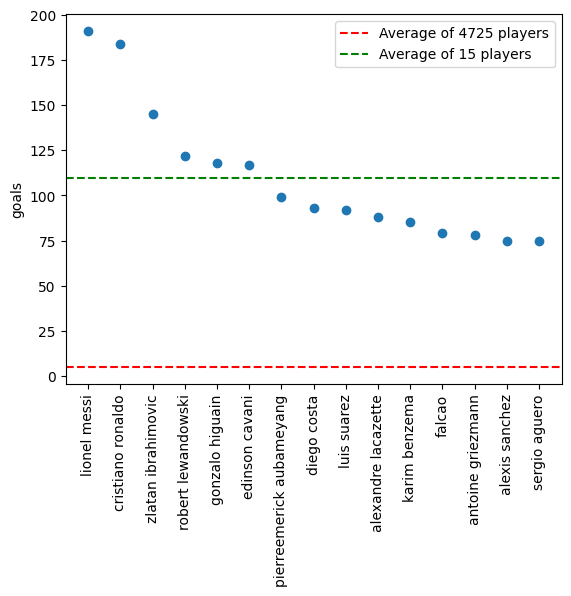

In [12]:
import matplotlib.pyplot as plt

plt.scatter(top_15_goals.index, top_15_goals)
plt.ylabel("goals")
plt.xticks(rotation=90)

all_avg = plt.axhline(
        y=np.nanmean(all_top_goals),
        color="red",
        linestyle="--",
        label=f"Average of {len(all_top_goals)} players")

top_avg = plt.axhline(
        y=np.nanmean(top_15_goals),
        color="green",
        linestyle="--",
        label=f"Average of 15 players")

plt.legend(handles=[all_avg, top_avg]);
plt.show()

This really puts into perspective on how the top players compare with an average player, with players like Lionel Messi and Cristiano Ronaldo being on a different level.

### Q. Which minutes of the game are the most intensive and worth watching?

Football is played for 90 minutes, with a 15 minute break after the first 45 minutes.
Not all minutes of the game are interesting, since most teams focus on possession of the ball, control of the overall dynamics of the game.

But it gets significantly intensive near the end of the first or the second half of the game in the sense that players give their all to score a goal and win the game. This means that the opposing team also try to actively defend the goal, tackling the attacking players and thus leading to them conceeding red/yellow cards.

To check if this is actually the general trend, we use the data we have and try to visualize it. We consider the goals, cards (both red and yellow) during the whole 90 minutes of the game.


##### Which minute of the game do players most often score?

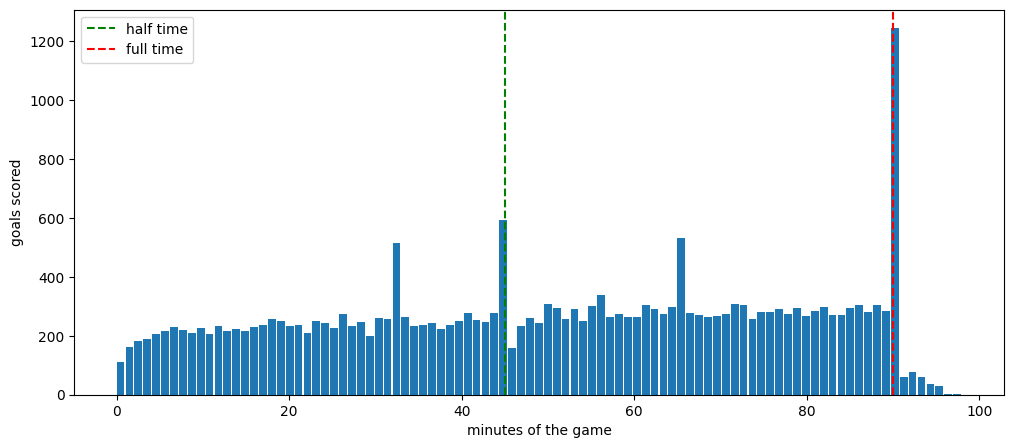

In [13]:
all_goals = data[data.is_goal == 1]
fig_g, ax_g = plt.subplots(figsize =(12, 5))
ax_g.hist(all_goals.time, bins = 95, width=0.9)

half_time = plt.axvline(
        x=45,
        color="green",
        linestyle="--",
        label="half time")

full_time = plt.axvline(
        x=90,
        color="red",
        linestyle="--",
        label="full time")

plt.xlabel("minutes of the game")
plt.ylabel("goals scored")

plt.legend(handles=[half_time, full_time]);

plt.show()

It seems interesting that players give their all to score at the end of the first and the second half, especially during the extra added time after the regular 90 minute game. But what about the opposing team - do they just give up when someone tries to attack at their end? If the strikers actively try to attack, then the opposing team would try to stop the attackers from scoring too.

To check if this is the case, we'll find what minutes of the game players are given the most cards. The more likely the opposing defenders try to actively defend, the more likely they are to receive cards, because more there are more chances of tackles, fouls.

Also, there are some spikes at around the 30 and the 65 minute mark of the game. This is likely because most teams already control the game dynamics by this point and become more comfortable pushing forward to score. The same with the 65 minute mark, since it takes some time after the half time whistle to regain the possession and control of the game.

##### Which minute of the game do players get shown cards(red/yellow) for foul play?

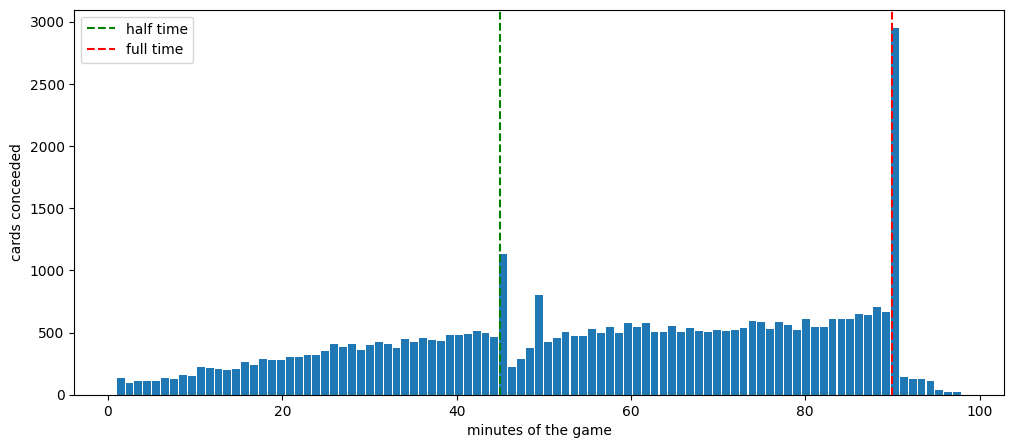

In [14]:
# We consider first yellow, second yellow and a straight red card for this

all_cards = data.loc[
    (data.event_type == "Yellow card") | 
    (data.event_type == "Second yellow card") |
    (data.event_type == "Red card")
]


fig_c, ax_c = plt.subplots(figsize =(12, 5))
ax_c.hist(all_cards.time, bins = 95, width=0.9)

half_time_c = plt.axvline(
        x=45,
        color="green",
        linestyle="--",
        label="half time")

full_time_c = plt.axvline(
        x=90,
        color="red",
        linestyle="--",
        label="full time")

plt.xlabel("minutes of the game")
plt.ylabel("cards conceeded")

plt.legend(handles=[half_time_c, full_time_c]);



As it was with the attacking side, the trend seems to be the same for the defending side too. So, it's not the attackers that give their everything at the end of the game after all. The defenders do everything they can to stop the attackers from scoring too - be it through tackles, fouls, rough play.

As a spectator, I find the end of the game the most interesting because of the thrill the whole experience brings.

### The last minutes of the game are interesting. But what about the month?

Here, we will analyze the distribution of goals of the top 5 european leagues, and try to see which months of the year the clubs produce the most goals, along with a breakdown of all individual leagues, and see if they have any similar patterns.

month
1     2357
2     2416
3     2461
4     2845
5     1905
6       38
8     1501
9     2816
10    2746
11    2521
12    2840
Name: is_goal, dtype: int64

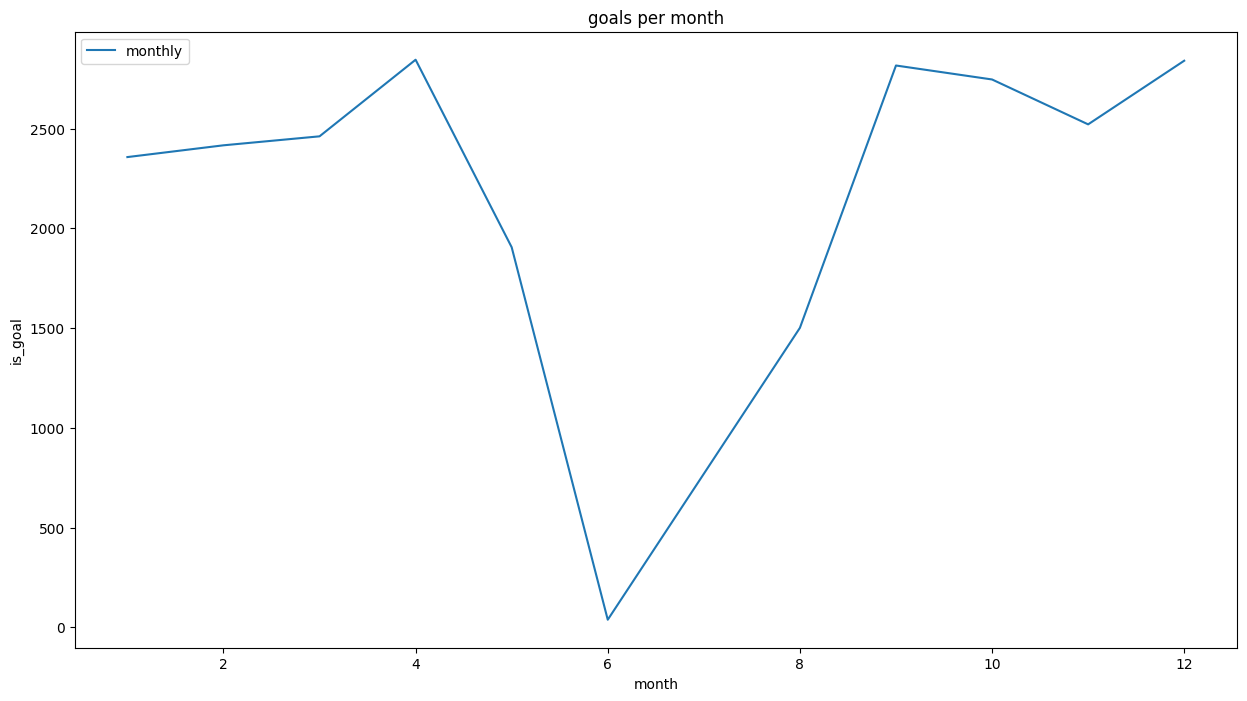

In [15]:
import seaborn as sns

#get all goals
all_g = data.copy()
all_g = all_g.loc[data.is_goal == 1]

#split the month part of the date and add it as a column
all_g["month"] = all_g["date"].apply(lambda x : int(x.split('-')[1]))

#get all goals for all months. There shouldn't be any goals on July due to international break
all_g_month = all_g.groupby("month").count()["is_goal"]

plt.figure(figsize=(15, 8))
sns.lineplot(data=all_g.groupby('month').count(), x='month', y='is_goal', label='monthly')
plt.title('goals per month')

all_g_month

It seems that August, September, October and December are very exciting months for football fans because those are when most goals usually occur.
The sudden increase in goals after the break on July explains that the players are very active after they take a month long break. And after a month of exercise, they get back to their best form, which is why they perform the best on September, October.

Now, we will check if this trend is the same for individual leagues.

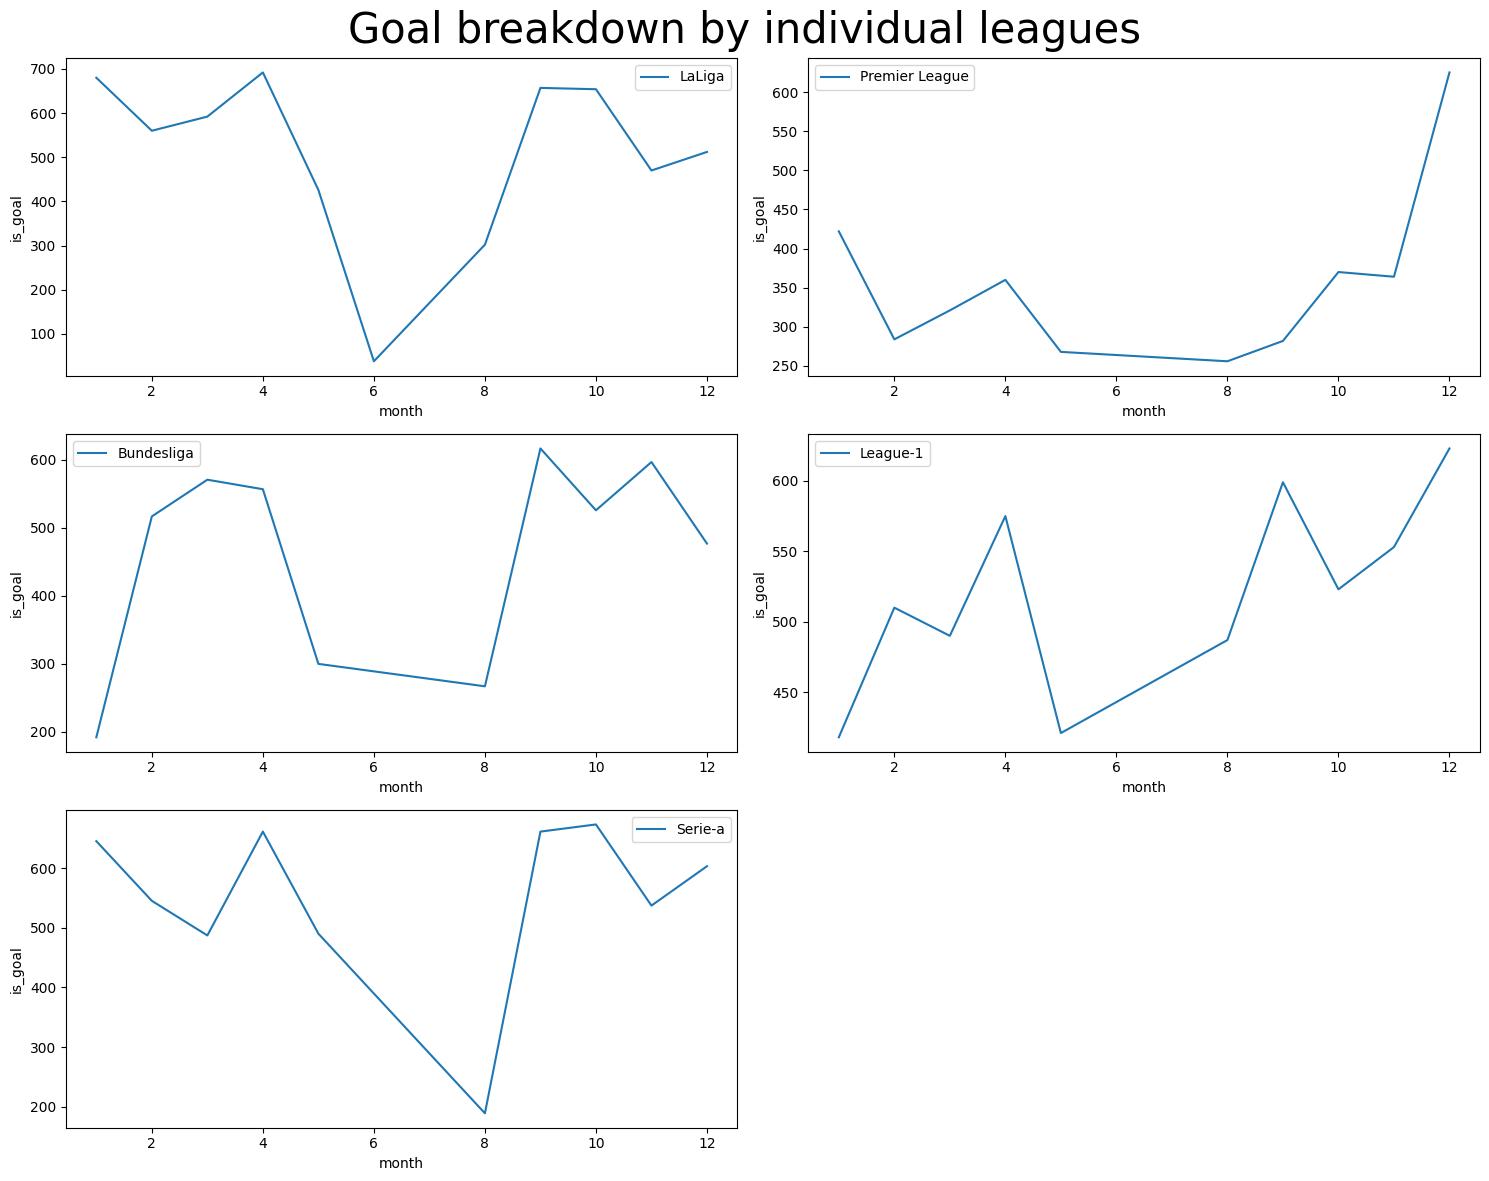

In [16]:
def get_data_for_league(league_name):
    ret = data.copy()
    ret = ret.loc[(data.league == league_name) & (data.is_goal == 1)]
    ret["month"] = ret["date"].apply(lambda x : int(x.split('-')[1]))
    return ret

def sns_plot(dta, axes):
    sns.lineplot(
        data=dta.groupby('month').count(),
        x='month',
        y='is_goal',
        label=dta.league.head(1).item(),
        ax=axes)

#get events for each individual leagues
spanish_league = get_data_for_league("LaLiga")
english_league = get_data_for_league("Premier League")
german_league = get_data_for_league("Bundesliga")
french_league = get_data_for_league("League-1")
italian_league = get_data_for_league("Serie-a")

fig, axs = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Goal breakdown by individual leagues', fontsize=30)
sns_plot(spanish_league, axs[0, 0])
sns_plot(english_league, axs[0, 1])
sns_plot(german_league, axs[1, 0])
sns_plot(french_league, axs[1, 1])
sns_plot(italian_league, axs[2, 0])

axs[2][1].axis('off')
plt.tight_layout()

The trend seems to be the same for all individual leagues. The players perform very well after they take a month long break, and when they get back to their original form in about a month after they rest, they seem to perform very well.

Also, the premier league seems to be the most competitive out of the 5 top leagues based on the graph above. For proper analysis, let's put all the information together and decide which league is the most and the least competitive.

Text(0.5, 1.0, 'goals per month')

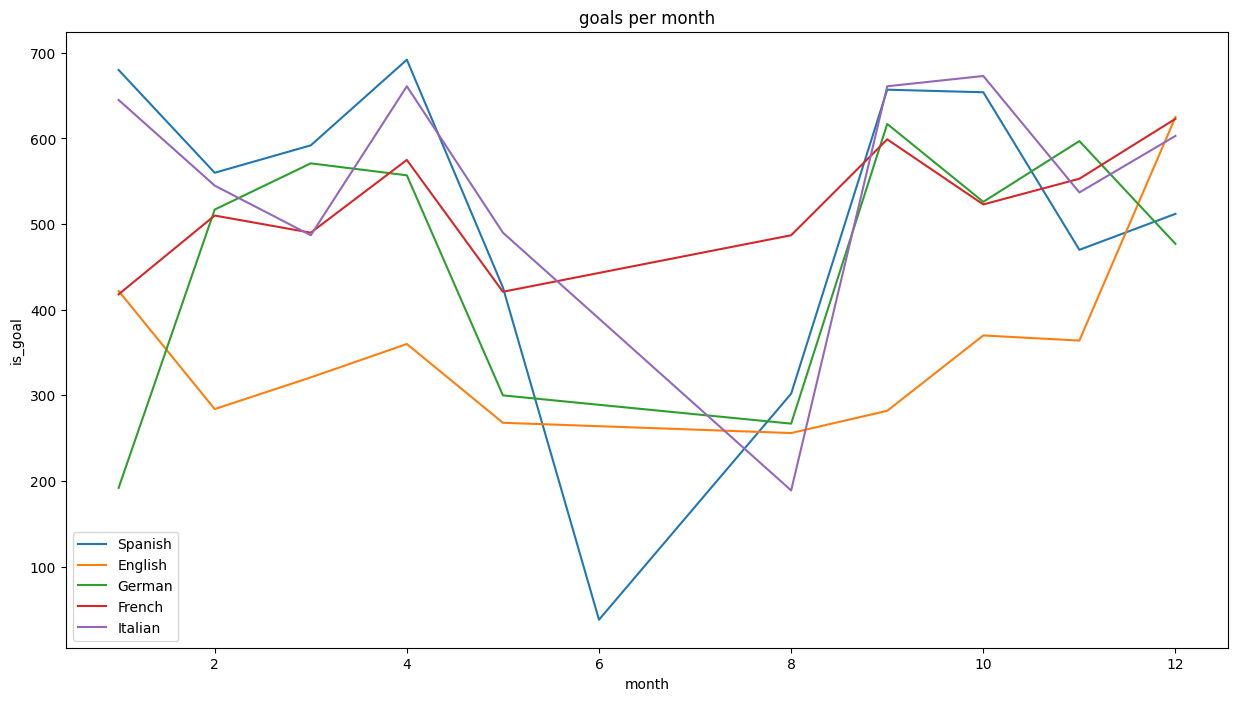

In [17]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=spanish_league.groupby('month').count(), x='month', y='is_goal', label='Spanish')
sns.lineplot(data=english_league.groupby('month').count(), x='month', y='is_goal', label='English')
sns.lineplot(data=german_league.groupby('month').count(), x='month', y='is_goal', label='German')
sns.lineplot(data=french_league.groupby('month').count(), x='month', y='is_goal', label='French')
sns.lineplot(data=italian_league.groupby('month').count(), x='month', y='is_goal', label='Italian')
plt.title('goals per month')

From this graph, it's easy to see that the Premier League is the most competitive out of all 5 leagues, with the Spanish and Italian leagues being one of the easiest.

Considering the fact that top scorers like Messi and Ronaldo were playing in the spanish league during this time, this makes it easy to see why the spanish league would have such high numbers in the graph.


# Expected Goal Classifier

Here, we will analyze our data and train a classifier that will take into account certain features that will likely result in a goal.
A football game is won by goals, and those goals come only from the shots. But we need to take into consideration the type of shots, whether the attacker shot in a close proximity of the goal, what body part was used for the shot, if the player scored on his/her own without any assists(which would make it a bit difficult than a player receiving an assist for a goal).
Then, using different classifiers, we would predict if a certain scenario results in a goal.

In [18]:
all_shots_n = data[data.event_type == "Attempt"]
pd.set_option('display.max_columns', None)

#keep only required columns for classification
is_goal = all_shots_n[["is_goal"]].reset_index(drop=True)

#also, some shots were not registered at all. We'll see how many unregistered shots there are
unregistered_shots = all_shots_n.loc[all_shots_n.location == "Not recorded"]
print(f"""
    Out of {all_shots_n.shape[0]} shot attempts,
    {unregistered_shots.shape[0]} shots were not registered,
    which means {(100 * (unregistered_shots.shape[0]/all_shots_n.shape[0])):.2f}% of the data is not useful to us.
    Out of the {unregistered_shots.shape[0]} unregistered shots, {len(unregistered_shots[unregistered_shots.is_goal == 1])} resulted in goal.""")

unregistered_shots.head(1)


    Out of 229135 shot attempts,
    1450 shots were not registered,
    which means 0.63% of the data is not useful to us.
    Out of the 1450 unregistered shots, 1438 resulted in goal.


,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
761,M7PhlM2C/,M7PhlM2C54,54,39,"Goal! Brest 1, Evian Thonon Gaillard 2. Bruno...",Attempt,NaN,Home,Brest,Evian Thonon Gaillard,bruno grougi,NaN,NaN,NaN,NaN,On target,1,Not recorded,right foot,None,Free kick,0,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,League-1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN


Now, we have relevant information for classification. We now prepare datasets __X__ and __y__ to train the model to perform classification.

For the train data __X__, we need to include all categorial features, i.e. for bodypart for example, we need to have left foot, right foot, head, etc. But since the original data had numerical value that referenced to a dictionary corresponding to the correct values, we could use those numerical values as our train/test data for classification.

Also, some shots weren't registered at all. This would be of little value when training the clasifier, so we discard these data.

For the train target __y__, we have the last column __is_goal__


In [19]:
#remove the inconsistent data for better classification,i.e. all shots that weren't registered
filtered_data = events_n.loc[
    (events_n.event_type == 1) &  #attempted shots
    (events_n.location != 19) & #only allowed shots
    (data.event_type2 != 15) #no own goal
]

X = filtered_data[
    ["time", "side", "location", "bodypart", "assist_method", "situation", "fast_break"]
].reset_index(drop=True)

y = filtered_data[["is_goal"]].reset_index(drop=True)

print(f"number of rows of the data = {X.shape[0]}")
X.head(2)


number of rows of the data = 227685


,time,side,location,bodypart,assist_method,situation,fast_break
0,2,2,9.0,2.0,1,1.0,0
1,14,1,15.0,1.0,1,1.0,0


We prepared the data for classification by using numeric features instead of one-hot encoding it. This makes it easier to understand what the features are by looking at the __dictionary.txt__ file We also have our target data, which is already in binary representation (1 for goal, 0 for not), so we don't have to process the target data


    Total goals were 23003.
    Out of 227685 registered shots, 10.10% resulted in goal


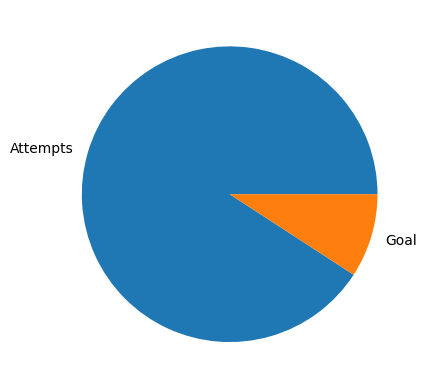

In [20]:
print(f"""
    Total goals were {y.is_goal.sum()}.
    Out of {y.shape[0]} registered shots, {100 * (y.is_goal.sum()/y.shape[0]):.2f}% resulted in goal""")

#pie chart represnting attempts and goals
plt_y = np.array([y.shape[0], y.is_goal.sum()])
labels = ["Attempts", "Goal"]

plt.pie(plt_y, labels = labels)
plt.show()

Now that we're done filtering the data, we use GridSearchCV along with stratified k-fold cross validation for hyperparameter tuning and to find the best model among the following classifiers:

1) Logistic Regression \
2) Gaussian Naive Bayes \
3) Decision Tree Classifier \
4) Gradient Boosting Classifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#### Hyperparameter tuning

In [22]:
model_params = {
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1,5,10]
        }
    },
    'gaussian_naive_bayes' : {
        'model': GaussianNB(),
        'params': {
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingClassifier(),
        'params' : {
            'learning_rate': [0.1, 0.01, 0.015]
        }
    },
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini','entropy'],
            'splitter' : ['best', 'random']
            
        }
    }     
}

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
scores = []
previous_score = 0.0
model = None

kFold = StratifiedKFold(5)

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=kFold)
    clf.fit(X, y)
    if clf.best_score_ > previous_score:
        previous_score = clf.best_score_
        model = clf
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

logistic_regression
gaussian_naive_bayes
gradient_boosting
decision_tree


,model,best_score,best_params
0,logistic_regression,0.899383,{'C': 5}
1,gaussian_naive_bayes,0.893225,{}
2,gradient_boosting,0.909880,{'learning_rate': 0.1}
3,decision_tree,0.898311,"{'criterion': 'gini', 'splitter': 'random'}"


From the table above, we can see that the gradient boosting classifier with the learning rate hyperparameter set to 0.1 would be the best choice, although the accuracy doesn't differ that much.

So, we use that to predict the number of goals for the top 15 players and compare with their actual results.

In [24]:
from sklearn.metrics import accuracy_score

players = filtered_data[["player"]]
goals = filtered_data[["is_goal"]]
test_x = filtered_data[["time", "side", "location", "bodypart", "assist_method", "situation", "fast_break"]]
prediction = model.predict(test_x)
print(f"accuracy = {accuracy_score(goals, model.predict(test_x)):.2f}")

#probability of a given shot to turn into a goal
test_x["prediction"] = model.predict_proba(test_x)[:, 1]
test_x["player"] = players
test_x["actual"] = goals
test_x["difference"] = test_x["prediction"] - test_x["actual"]

new_stats = (test_x.groupby("player").sum()[["prediction", "actual", "difference"]]).sort_values(by="actual", ascending=False)
new_stats

accuracy = 0.91


,prediction,actual,difference
player,,,
lionel messi,131.288784,191,-59.711216
cristiano ronaldo,151.688559,184,-32.311441
zlatan ibrahimovic,109.928429,145,-35.071571
robert lewandowski,93.568107,122,-28.431893
gonzalo higuain,84.375719,118,-33.624281
...,...,...,...
jonathan zebina,3.149277,0,3.149277
lukasz skorupski,0.125631,0,0.125631
luke garbutt,0.021637,0,0.021637


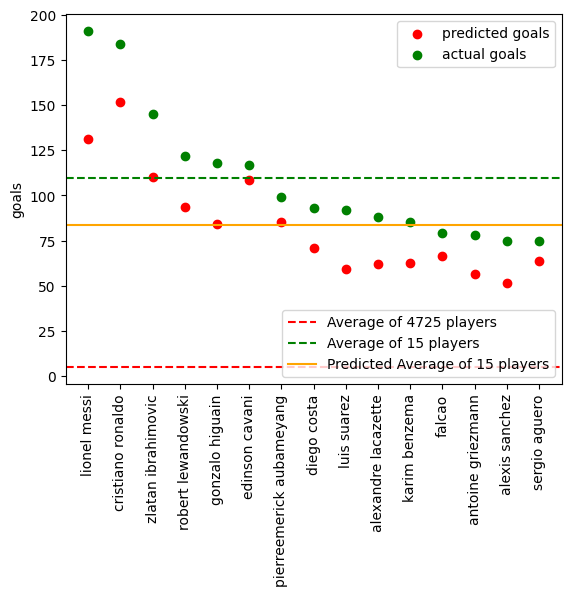

In [25]:
new_stats_15 = new_stats.head(15)

fig, ax = plt.subplots()

pr = ax.scatter(new_stats_15.index, new_stats_15["prediction"], c="red", label="predicted goals")
act = ax.scatter(new_stats_15.index, new_stats_15["actual"], c="green", label="actual goals")
plt.ylabel("goals")
plt.xticks(rotation=90)

all_avg = ax.axhline(
        y=np.nanmean(new_stats["actual"]),
        color="red",
        linestyle="--",
        label=f"Average of {len(new_stats)} players")


top_avg = ax.axhline(
        y=np.nanmean(new_stats_15["actual"]),
        color="green",
        linestyle="--",
        label=f"Average of 15 players")

top_pred_avg = ax.axhline(
        y=np.nanmean(new_stats_15["prediction"]),
        color="orange",
        linestyle="-",
        label=f"Predicted Average of 15 players")

l1 = ax.legend(handles=[pr, act], loc="upper right")
ax.add_artist(l1)
l2 = ax.legend(handles=[all_avg, top_avg, top_pred_avg], loc="lower right")

plt.show()

## Clustering the teams based on their gameplay and performance

### Q. Is the only way to get good results in a league to have footballs stars? Can a team perform equally well if they all coordinate and play competitively?

In [26]:
gameplay_reqs = ["event_team", "shot_place", "shot_outcome",
     "location", "assist_method", "situation", "fast_break", "is_goal"]

all_teams = events_n[gameplay_reqs].dropna()

print(f"There are {len(pd.unique(all_teams['event_team']))} teams in the dataset")

There are 142 teams in the dataset


In [27]:
grouped_teams = all_teams.groupby("event_team")[gameplay_reqs[1:]].agg(list)
grouped_teams.head(1)

,shot_place,shot_outcome,location,assist_method,situation,fast_break,is_goal
event_team,,,,,,,
AC Ajaccio,"[5.0, 2.0, 6.0, 10.0, 8.0, 2.0, 6.0, 5.0, 2.0,...","[1.0, 3.0, 2.0, 2.0, 2.0, 3.0, 2.0, 1.0, 3.0, ...","[3.0, 15.0, 12.0, 3.0, 3.0, 15.0, 3.0, 3.0, 15...","[2, 1, 2, 0, 2, 0, 2, 2, 0, 1, 2, 1, 2, 0, 3, ...","[1.0, 1.0, 3.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Now, we'll cluster the clubs and see based on different features which tiers the clubs lie in.

We'll use features such as total number of goals, circumstances, play methods, and we will also factor in the goal scoring ratio of the top 3 players in the team

In [28]:
cluster_dataset = pd.DataFrame()
cluster_dataset["teams"] = pd.unique(all_teams['event_team'])
teams_ = cluster_dataset["teams"]

for reqs in gameplay_reqs[1:]:
    unique_categories = all_teams[reqs].unique()
    for cat in unique_categories:
        new_feature = f"{reqs}_{cat if not reqs in dictionary else dictionary[reqs][cat]}"
        cluster_dataset[new_feature] = None
        
        for i in range(len(grouped_teams)):
            
            all_vals = grouped_teams \
                .loc[cluster_dataset \
                .at[i, "teams"], reqs]
            
            cluster_dataset.at[i, new_feature] = \
                sum([1 if val == cat else 0 for val in all_vals ])
cluster_dataset

,teams,shot_place_High and wide,shot_place_Top right corner,shot_place_Bottom right corner,shot_place_Blocked,shot_place_Hits the bar,shot_place_Centre of the goal,shot_place_Misses to the right,shot_place_Too high,shot_place_Misses to the left,shot_place_Top centre of the goal,shot_place_Bottom left corner,shot_place_Top left corner,shot_place_Bit too high,shot_outcome_Off target,shot_outcome_On target,shot_outcome_Blocked,shot_outcome_Hit the bar,location_Left side of the box,location_Outside the box,location_Centre of the box,location_Right side of the box,location_Very close range,location_Long range,location_More than 35 yards,location_Difficult angle on the left,location_Difficult angle on the right,location_Right side of the six yard box,location_Left side of the six yard box,location_Difficult angle and long range,location_Not recorded,location_Penalty spot,location_More than 40 yards,assist_method_Pass,assist_method_None,assist_method_Cross,assist_method_Headed pass,assist_method_Through ball,situation_Open play,situation_Corner,situation_Free kick,situation_Set piece,fast_break_0,fast_break_1,is_goal_0,is_goal_1
0,Hamburg SV,156,45,154,480,31,275,266,140,250,61,169,71,72,912,747,480,31,212,851,671,150,65,36,33,21,31,26,27,24,4,17,2,1024,608,404,91,43,1816,176,46,132,2108,62,1997,173
1,Borussia Dortmund,176,76,244,686,52,440,261,208,312,65,222,67,87,1074,1084,686,52,285,1008,1041,240,88,14,28,35,20,34,45,21,8,25,4,1516,760,441,93,86,2446,243,72,135,2807,89,2538,358
2,FC Augsburg,174,71,158,566,37,240,266,155,260,55,166,76,78,976,723,566,37,201,1001,664,204,40,28,18,19,14,32,26,19,7,23,6,1101,638,413,112,38,1958,151,56,137,2239,63,2115,187
3,SC Freiburg,121,52,127,402,33,174,139,78,156,32,147,50,42,573,545,402,33,155,630,441,128,37,14,23,16,20,26,26,12,3,19,3,819,422,230,54,28,1345,97,32,79,1491,62,1400,153
4,Werder Bremen,132,80,204,550,38,251,229,162,301,51,175,67,60,921,791,550,38,184,885,721,183,67,34,15,25,31,40,50,24,11,27,3,1076,667,411,108,38,1898,206,49,147,2230,70,2064,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Middlesbrough,15,5,11,60,2,20,21,8,35,4,9,3,4,84,51,60,2,20,86,52,16,8,0,1,3,4,2,4,0,0,1,0,79,61,42,13,2,171,14,4,8,194,3,180,17
138,Alaves,15,9,10,30,4,23,26,14,13,5,11,4,4,79,55,30,4,11,54,70,12,3,2,3,2,3,2,1,2,0,1,2,69,45,41,9,4,134,22,2,10,165,3,151,17
139,Crotone,17,2,14,43,8,23,22,20,19,11,13,5,1,80,67,43,8,19,73,67,10,7,0,5,2,2,3,3,1,1,4,1,89,58,43,8,0,165,16,3,14,198,0,182,16
140,Leganes,8,9,21,50,0,29,28,23,20,3,11,3,3,85,73,50,0,18,90,54,17,5,3,5,4,5,1,3,0,1,2,0,95,62,34,12,5,177,14,4,13,206,2,193,15


Now that we're done adding all gameplay types of the teams, we also add 3 new columns top_1, top_2 and top_3 that specify what the goal ratio of the 3 best players were. This will help us compare teams based on stars and/or gameplay.

In [29]:
import os
top_ratio_dataset = None
if os.path.exists("top_ratio.csv"):
    top_ratio_dataset = pd.read_csv("top_ratio.csv")
else:
    top_ratio_dataset = pd.DataFrame()
    top_ratio_dataset["event_team"] = None
    top_ratio_dataset["top_1"] = None
    top_ratio_dataset["top_2"] = None
    top_ratio_dataset["top_3"] = None

    b = events_n[["event_team", "player", "event_type", "is_goal"]].dropna()
    b = b.loc[b["event_type"] == 1]
    a = b.groupby("event_team")["player"].agg(set)

    dta = data.loc[(data.event_type == "Attempt") & 
                    (data.event_type2 != "Own goal") &
                    (data.location != "Not recorded")][["date", "is_goal", "event_team", "player"]]

    for club, all_players in a.iteritems():
        top_ratios = [0] * 3
        for player in all_players:
            all_goals_for_the_player = dta.loc[
                    (data.player == player) &
                    (data.event_team == club)][["date", "is_goal"]]

            # ratio = total goals / games played, so we sort the data by date.
            goal_date_sum = all_goals_for_the_player.groupby("date").sum()
            ratio = all_goals_for_the_player.is_goal.sum() / all_goals_for_the_player.shape[0]
            
            #instead of appending everything to a list and reverse sorting it, we only add 3 elements to the list
            # but keep a track of the top 3 ratios.
            if ratio > top_ratios[0]:
                if top_ratios[0] > top_ratios[1]:
                    if top_ratios[2] > top_ratios[1]:
                        top_ratios[2] = top_ratios[1]
                    top_ratios[1] = top_ratios[0]
                top_ratios[0] = ratio

            elif ratio > top_ratios[1]:
                if top_ratios[2] > top_ratios[1]:
                    top_ratios[2] = top_ratios[1]
                top_ratios[1] = ratio
            elif ratio > top_ratios[2]:
                top_ratios[2] = ratio

        top_ratio_dataset = top_ratio_dataset.append({
            "event_team" : club,
            "top_1" : top_ratios[0],
            "top_2" : top_ratios[1],
            "top_3" : top_ratios[2]}, ignore_index=True)

    #since it takes a lot of time to process this information, we store it if this file doesn't already exist.
    top_ratio_dataset.to_csv("top_ratio.csv")
    
if "Unnamed: 0" in top_ratio_dataset:
    top_ratio_dataset.drop("Unnamed: 0", axis=1, inplace=True)
top_ratio_dataset.loc[top_ratio_dataset.event_team == "Hamburg SV"]

,event_team,top_1,top_2,top_3
58,Hamburg SV,0.307692,0.166667,0.153846


From the table above, we can see that the best goalscorer for __Hamburg SV__ had a goal scoring ratio of 0.3, i.e. he used to score a goal in approximately 3-4 games.

Now that we have the top 3 goal scoring ratio for all clubs, we add this information to the dataset we will cluster and compare

In [30]:
cluster_dataset["top_1"] = None
cluster_dataset["top_2"] = None
cluster_dataset["top_3"] = None
for i in range(cluster_dataset.shape[0]):
    team_to_update = cluster_dataset.at[i, "teams"]
    ratios = top_ratio_dataset.loc[top_ratio_dataset.event_team == team_to_update]
    cluster_dataset.at[i, "top_1"] = float(ratios.top_1)
    cluster_dataset.at[i, "top_2"] = float(ratios.top_2)
    cluster_dataset.at[i, "top_3"] = float(ratios.top_3)
cluster_dataset
    

,teams,shot_place_High and wide,shot_place_Top right corner,shot_place_Bottom right corner,shot_place_Blocked,shot_place_Hits the bar,shot_place_Centre of the goal,shot_place_Misses to the right,shot_place_Too high,shot_place_Misses to the left,shot_place_Top centre of the goal,shot_place_Bottom left corner,shot_place_Top left corner,shot_place_Bit too high,shot_outcome_Off target,shot_outcome_On target,shot_outcome_Blocked,shot_outcome_Hit the bar,location_Left side of the box,location_Outside the box,location_Centre of the box,location_Right side of the box,location_Very close range,location_Long range,location_More than 35 yards,location_Difficult angle on the left,location_Difficult angle on the right,location_Right side of the six yard box,location_Left side of the six yard box,location_Difficult angle and long range,location_Not recorded,location_Penalty spot,location_More than 40 yards,assist_method_Pass,assist_method_None,assist_method_Cross,assist_method_Headed pass,assist_method_Through ball,situation_Open play,situation_Corner,situation_Free kick,situation_Set piece,fast_break_0,fast_break_1,is_goal_0,is_goal_1,top_1,top_2,top_3
0,Hamburg SV,156,45,154,480,31,275,266,140,250,61,169,71,72,912,747,480,31,212,851,671,150,65,36,33,21,31,26,27,24,4,17,2,1024,608,404,91,43,1816,176,46,132,2108,62,1997,173,0.307692,0.166667,0.153846
1,Borussia Dortmund,176,76,244,686,52,440,261,208,312,65,222,67,87,1074,1084,686,52,285,1008,1041,240,88,14,28,35,20,34,45,21,8,25,4,1516,760,441,93,86,2446,243,72,135,2807,89,2538,358,0.5,0.333333,0.222222
2,FC Augsburg,174,71,158,566,37,240,266,155,260,55,166,76,78,976,723,566,37,201,1001,664,204,40,28,18,19,14,32,26,19,7,23,6,1101,638,413,112,38,1958,151,56,137,2239,63,2115,187,0.5,0.375,0.285714
3,SC Freiburg,121,52,127,402,33,174,139,78,156,32,147,50,42,573,545,402,33,155,630,441,128,37,14,23,16,20,26,26,12,3,19,3,819,422,230,54,28,1345,97,32,79,1491,62,1400,153,0.666667,0.4,0.2
4,Werder Bremen,132,80,204,550,38,251,229,162,301,51,175,67,60,921,791,550,38,184,885,721,183,67,34,15,25,31,40,50,24,11,27,3,1076,667,411,108,38,1898,206,49,147,2230,70,2064,236,0.5,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Middlesbrough,15,5,11,60,2,20,21,8,35,4,9,3,4,84,51,60,2,20,86,52,16,8,0,1,3,4,2,4,0,0,1,0,79,61,42,13,2,171,14,4,8,194,3,180,17,0.333333,0.25,0.25
138,Alaves,15,9,10,30,4,23,26,14,13,5,11,4,4,79,55,30,4,11,54,70,12,3,2,3,2,3,2,1,2,0,1,2,69,45,41,9,4,134,22,2,10,165,3,151,17,0.285714,0.2,0.2
139,Crotone,17,2,14,43,8,23,22,20,19,11,13,5,1,80,67,43,8,19,73,67,10,7,0,5,2,2,3,3,1,1,4,1,89,58,43,8,0,165,16,3,14,198,0,182,16,1.0,0.4,0.166667
140,Leganes,8,9,21,50,0,29,28,23,20,3,11,3,3,85,73,50,0,18,90,54,17,5,3,5,4,5,1,3,0,1,2,0,95,62,34,12,5,177,14,4,13,206,2,193,15,0.333333,0.25,0.157895


Now, using the sum of squared distances of samples to their closest cluster center, we try to find a good number for clustering.
We use the elbow technique to find a good number for this

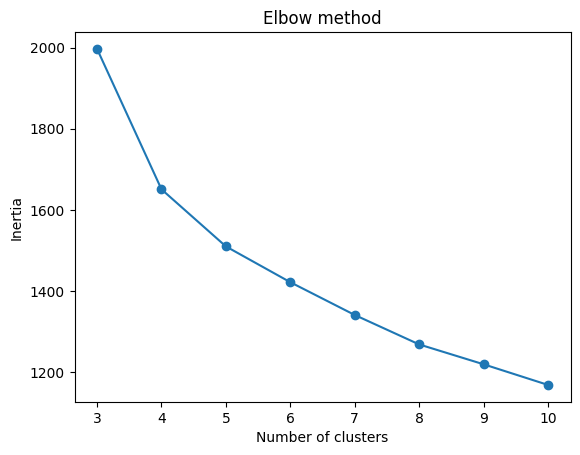

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_dataset_copy = cluster_dataset.copy()
if 'teams' in cluster_dataset_copy:
    cluster_dataset_copy.drop('teams', axis=1, inplace=True)
    
scaler = StandardScaler()
cluster_dataset_copy = pd.DataFrame(scaler.fit_transform(cluster_dataset_copy))

inertias = []

for i in range(3,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cluster_dataset_copy)
    inertias.append(kmeans.inertia_)

plt.plot(range(3,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

From the graph above, we can see that cluster size 4 would be the best option for us

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,labels,x,y,teams
0,0.709334,0.023543,0.271373,0.476475,0.352242,0.905818,0.947317,0.465545,0.572023,1.063869,0.500201,1.179993,1.045296,0.739357,0.634951,0.476475,0.352242,0.978719,0.529647,0.651842,0.272485,0.667749,2.303199,1.985308,0.249521,1.165296,0.143102,0.182075,1.840919,-0.335098,-0.054112,0.11484,0.568254,0.815497,0.602915,1.316332,-0.183768,0.609389,0.68713,0.325443,1.183572,0.62125,1.256467,0.709987,0.116651,-0.678528,-0.889152,-0.83989,0,4.187737,-2.516702,Hamburg SV


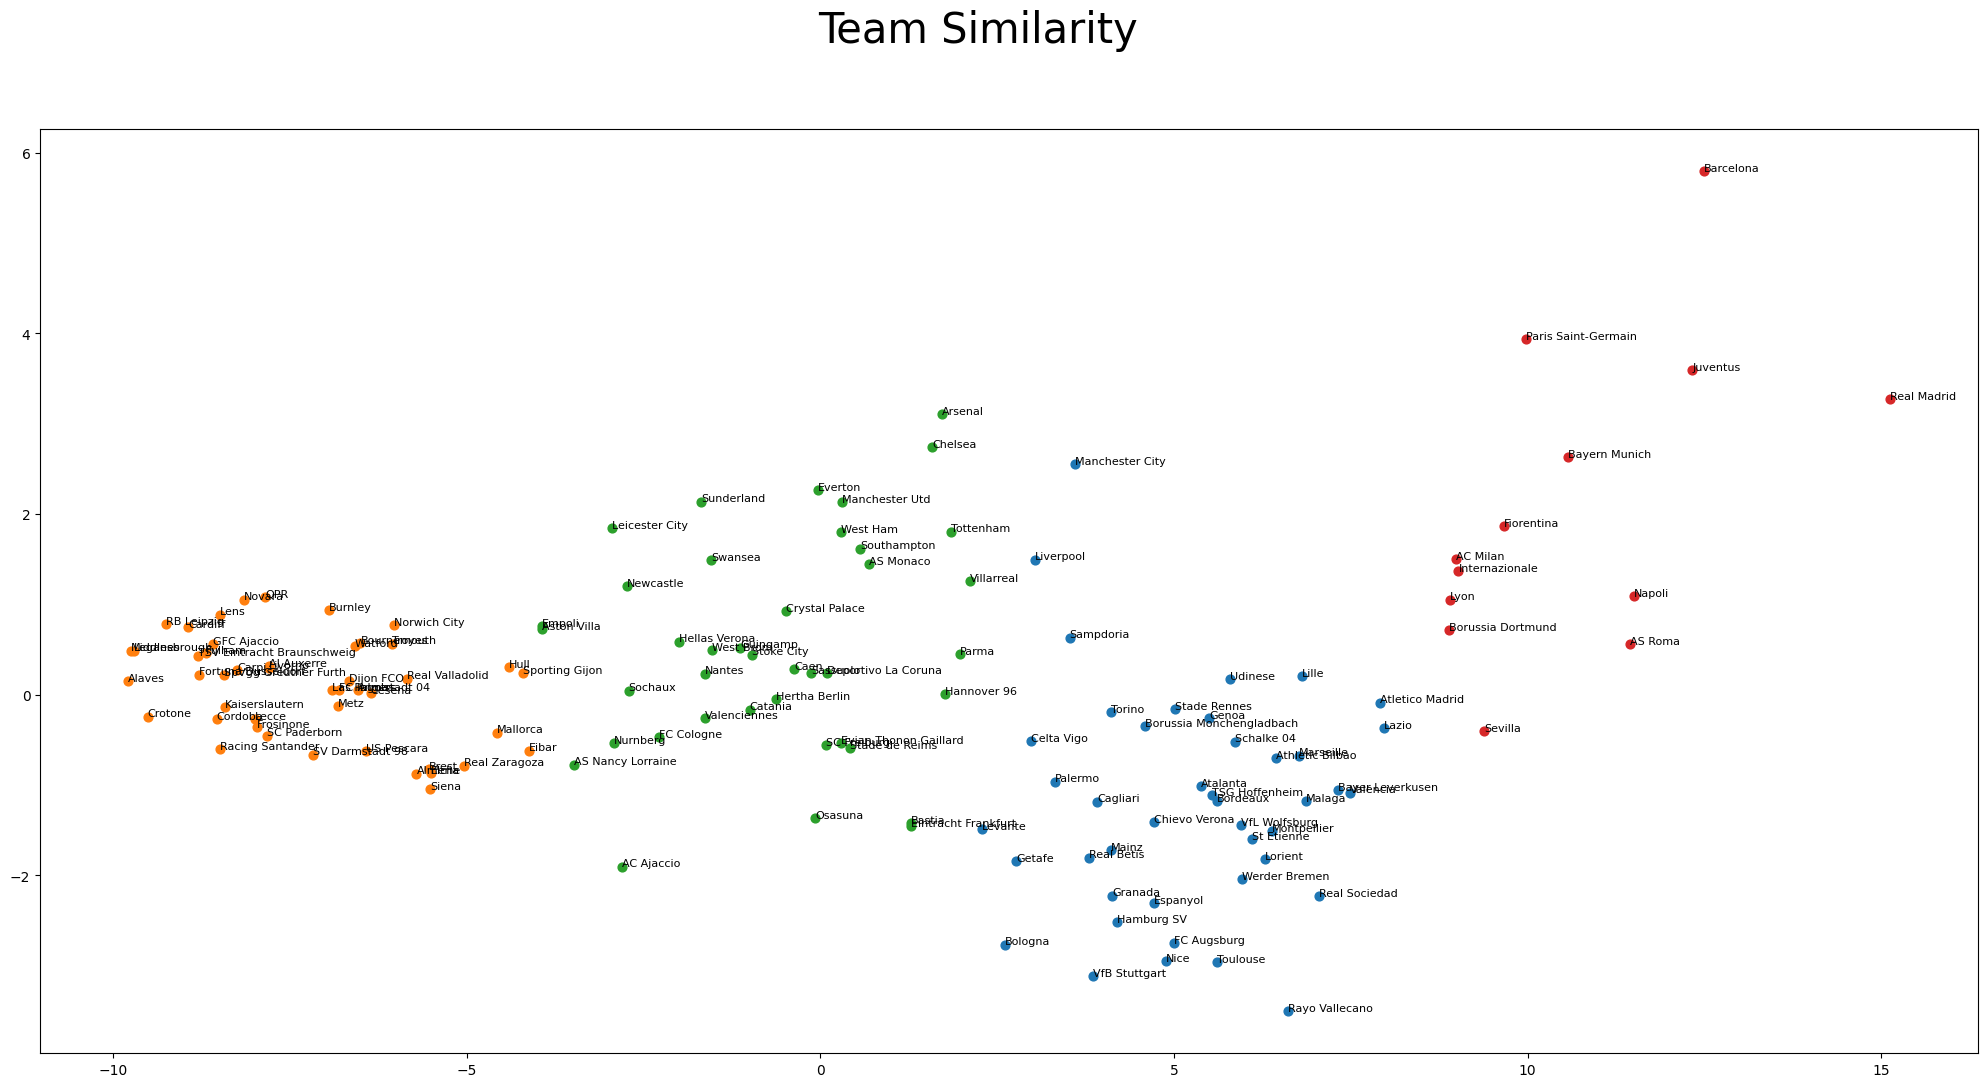

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

N_CLUSTERS=4

#kmeans
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(cluster_dataset_copy)

y_pred = kmeans.predict(cluster_dataset_copy)

cluster_dataset_copy["labels"] = kmeans.labels_

#pca
pca = PCA(2)
cluster_dataset_pca = pca.fit_transform(cluster_dataset_copy)
cluster_dataset_copy["x"] = cluster_dataset_pca[:, 0]
cluster_dataset_copy["y"] = cluster_dataset_pca[:, 1]

cluster_dataset_copy["teams"] = teams_


#plot the labels
fig, ax = plt.subplots(figsize=(25,12))

fig.suptitle('Team Similarity',fontsize=30)
for i in range(N_CLUSTERS):
    filt=cluster_dataset_copy[cluster_dataset_copy['labels'] == i]
    t=filt['teams'].tolist()
    ax.scatter(filt['x'],filt['y'], s=40)
    
for i in range(142):
    team_name = cluster_dataset_copy.at[i, "teams"]
    cur_x = cluster_dataset_copy.at[i, "x"]
    cur_y = cluster_dataset_copy.at[i, "y"]
    plt.text(cur_x, cur_y, team_name, fontsize=8)
    
cluster_dataset_copy.head(1)

We now plot each clusters on different graphs and see if the big clubs have similar playing styles

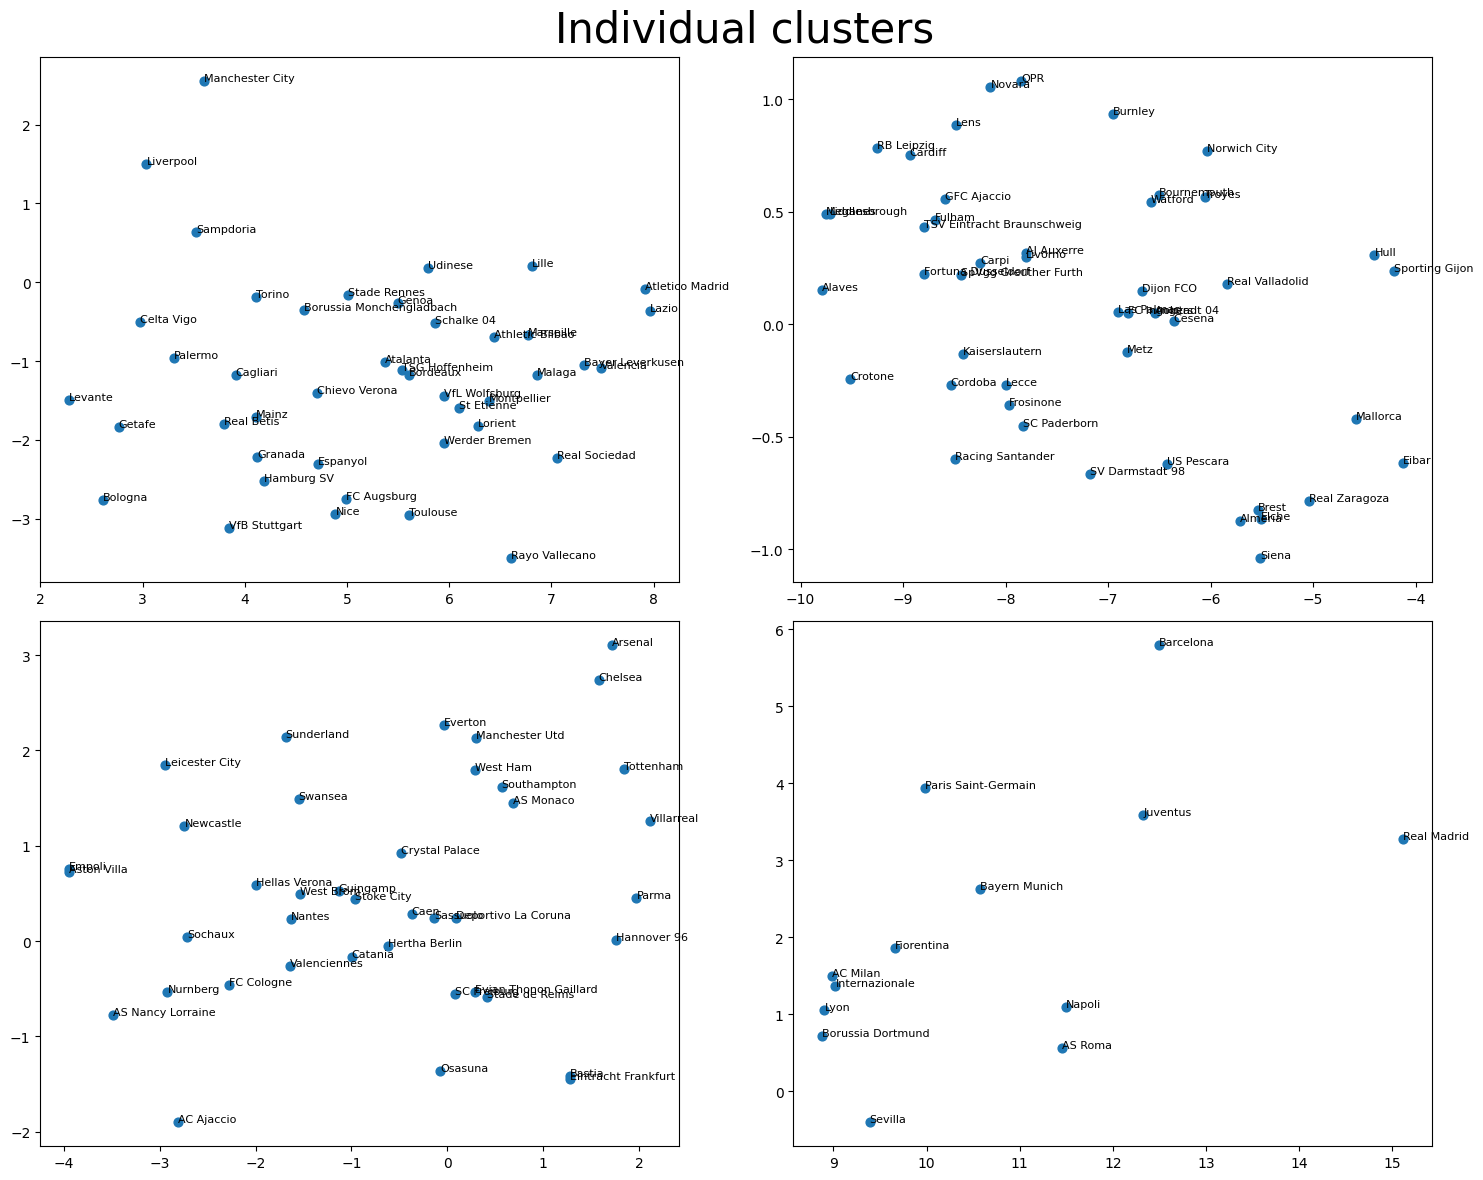

In [33]:
import math

fig, axs = plt.subplots(math.ceil(N_CLUSTERS/2), 2, figsize=(15, 12))
fig.suptitle('Individual clusters', fontsize=30)

curr_label = 0
for i in range(math.ceil(N_CLUSTERS/2)):
    for j in range(2):
        data_clust = cluster_dataset_copy[cluster_dataset_copy.labels == curr_label]
        axs[i, j].scatter(data_clust["x"], data_clust["y"], s=40)
        curr_label += 1
        for k, row in data_clust.iterrows():
            team_n = row["teams"]
            c_x = row["x"]
            c_y = row["y"]
            axs[i, j].text(c_x, c_y, team_n, fontsize=8)

if (N_CLUSTERS % 2 == 1):
    axs[math.ceil(N_CLUSTERS/2)][1].axis('off')
plt.tight_layout()

From this, we can clearly see that big teams like FC Barcelona, Real Madrid, PSG have similar gameplay style.\
Some of the big tier clubs doen't have any special player, but it's the whole team that play very competitively, making them great. \
So, to answer the question __"Is either 'one star' or 'a group' distribution better in the league results?"__, we can see that teams don't necessarily need a star in it to get good league results. They can also perform equally well, if not better, if they all focus on teamplay and coordination. A very good example of this is __Bayern Munich__, who always beat FC Barcelona by a big margin on Champions League because their team coordination is far better than that of FC Barcelona.